In [22]:
import cv2
import os
from os import listdir
from os.path import isfile, join
from PIL import Image as Image
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.pyplot as plt

In [23]:
def relit(img, m, w, b):
    x = img.astype(float) / 255
    masked_pixels = x[m > 0]
    mean_x = np.mean(masked_pixels)  # Calcola la media di x (mu(I_s))
    std_x = np.std(masked_pixels)  # Calcola la deviazione standard di x (sd(I_s))
    return (b + ((x - mean_x) * (w / std_x))) * 255

sd_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train/train_A'
mask_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train/train_B'
sdfree_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train/train_C'

out = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train_params/'
if not os.path.exists(out):
    os.makedirs(out)

im_list  =  [f for f in listdir(sd_path) if isfile(join(sd_path, f)) and f.endswith('png')]

kernel = np.ones((5,5),np.uint8)


def im_relit(Rpopt, Gpopt, Bpopt, dump, mask):
    sdim = dump.copy()
    sdim.setflags(write=1)
    sdim = sdim.astype(float)

    # Applica la nuova formula ai canali R, G, B
    sdim[:, :, 0] = relit(sdim[:, :, 0], mask, Rpopt[0], Rpopt[1])  # Canale rosso
    sdim[:, :, 1] = relit(sdim[:, :, 1], mask, Gpopt[0], Gpopt[1])  # Canale verde
    sdim[:, :, 2] = relit(sdim[:, :, 2], mask, Bpopt[0], Bpopt[1])  # Canale blu

    return sdim


errors= []
for im in tqdm(im_list, desc="Elaborazione delle immagini"):
    # Carica le immagini con ombra e senza ombra
    I_s = np.asarray(Image.open(join(sd_path, im)))  # I_s
    mask_ori = np.asarray(Image.open(join(mask_path, im)))
    binary_mask = (mask_ori >= 1).astype(np.uint8)
    mask = cv2.erode(binary_mask, kernel, iterations=2)

    I_ns = np.asarray(Image.open(join(sdfree_path, im)))  # I_ns
    
    mean_I_s = np.mean(I_s, axis=2)  # Media dell'immagine con ombra
    mean_I_ns = np.mean(I_ns, axis=2)  # Media dell'immagine senza ombra

    # Seleziona i pixel per la regressione
    i, j = np.where(np.logical_and(
        np.logical_and(np.logical_and(mask >= 1, mean_I_s > 5), mean_I_ns < 230), 
        np.abs(mean_I_s - mean_I_ns) > 10
    ))

    # Estrai le regioni dei pixel con ombra e senza ombra
    source = np.zeros_like(I_s)
    target = np.zeros_like(I_s)
    source[i, j] = I_s[i, j]
    target[i, j] = I_ns[i, j]

    # Separa i canali R, G, B
    R_s, G_s, B_s = source[i, j, 0], source[i, j, 1], source[i, j, 2]
    R_t, G_t, B_t = target[i, j, 0], target[i, j, 1], target[i, j, 2]
    
    # Definisci i limiti per i parametri w e b
    c_bounds = [[-0.5, -3], [3, 3]]  # Limiti dei parametri w e b

    def relit_flat(x, w, b):
        x_reshaped = x.reshape(-1)  # Assicura che x sia un array monodimensionale
        return relit(x_reshaped, mask[i, j], w, b)

    # Regressione per i canali R, G, B con la maschera fissata
    Rpopt, _ = curve_fit(relit_flat, R_s, R_t, bounds=c_bounds)  # Canale rosso
    Gpopt, _ = curve_fit(relit_flat, G_s, G_t, bounds=c_bounds)  # Canale verde
    Bpopt, _ = curve_fit(relit_flat, B_s, B_t, bounds=c_bounds) 


    # Riapplica la ri-illuminazione sull'immagine originale
    relitim = im_relit(Rpopt, Gpopt, Bpopt, I_s, mask)

    # Calcola l'errore medio assoluto tra immagine ri-illuminata e immagine senza ombra
    error = np.mean(np.abs(relitim[i, j].astype(float) - I_ns[i, j].astype(float)))
    errors.append(error)

    # Salva i parametri ottimizzati in un file
    with open(join(out, im + '.txt'), 'a') as f:
        f.write("%f %f %f %f %f %f\n" % (Rpopt[0], Rpopt[1], Gpopt[0], Gpopt[1], Bpopt[0], Bpopt[1]))
    
print(f"Errore medio: {np.mean(errors)}")

Elaborazione delle immagini: 100%|██████████| 1330/1330 [08:31<00:00,  2.60it/s]

Errore medio: 8.81001851585902


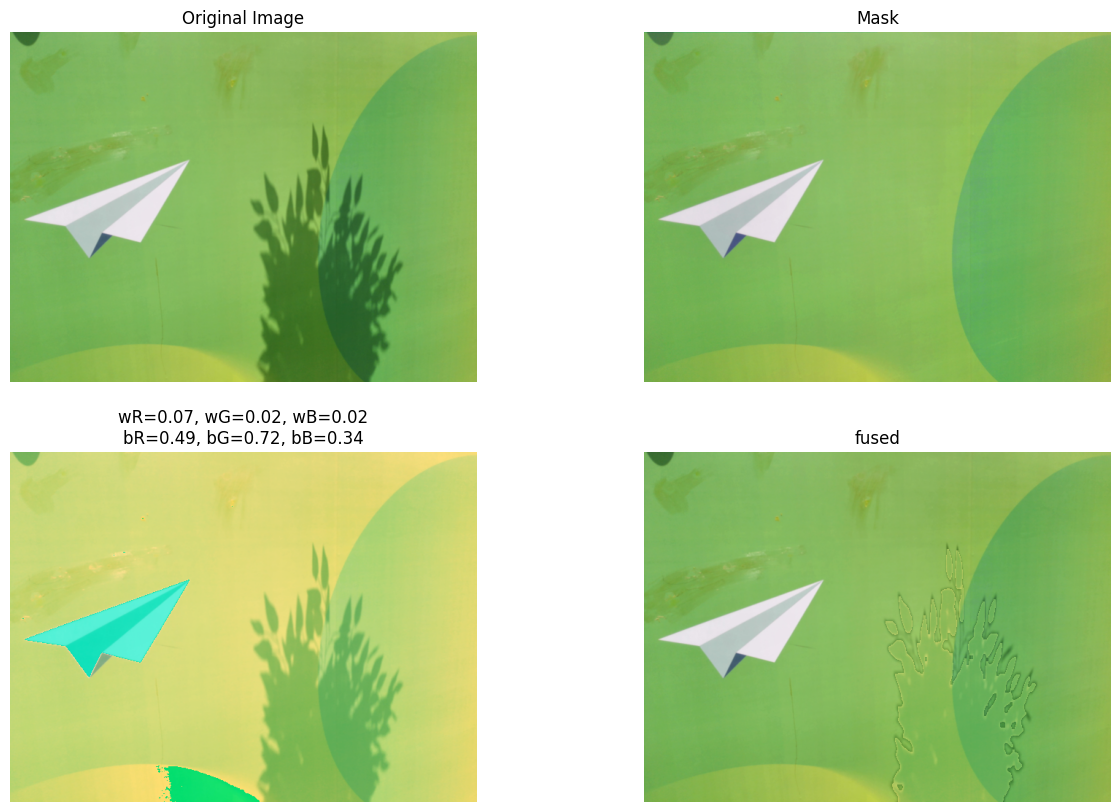

In [21]:
def relit(img, m, w, b):
    x = img.astype(float) / 255
    masked_pixels = x[m > 0]
    mean_x = np.mean(masked_pixels)  # Calcola la media di x (mu(I_s))
    std_x = np.std(masked_pixels)  # Calcola la deviazione standard di x (sd(I_s))
    return (b + ((x - mean_x) * (w / std_x))) * 255

def plshow(im, title='MINE'):
    plt.imshow(im)
    plt.title(title)
    plt.axis('off')  # Nasconde gli assi
    plt.show()

# Percorsi delle immagini e dei parametri
im_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train/train_A/58-8.png'
m_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train/train_B/58-8.png'
gt_path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_adjusted/train/train_C/58-8.png'
par = '/home/vhaardt/Desktop/ShadowRemoval/code/Shadow-Removal-1/train_params/58-8.png.txt'

# Carica l'immagine, la maschera e l'immagine di riferimento
I_s = np.asarray(Image.open(im_path))
mask = np.asarray(Image.open(m_path))
mask = (mask >= 1).astype(np.uint8)
I_ns = np.asarray(Image.open(gt_path))

# Estrai i parametri dal file
with open(par, "r") as f:
    # Legge tutti i parametri e li converte in float
    params = list(map(float, f.readline().strip().split()))

    Rpopt = (params[0], params[1])  # (w, b) per il canale rosso
    Gpopt = (params[2], params[3])  # (w, b) per il canale verde
    Bpopt = (params[4], params[5])  # (w, b) per il canale blu

# Riapplica la ri-illuminazione separatamente per ogni canale
relit_red = relit(I_s[:, :, 0], mask, Rpopt[0], Rpopt[1])  # Canale rosso
relit_green = relit(I_s[:, :, 1], mask, Gpopt[0], Gpopt[1])  # Canale verde
relit_blue = relit(I_s[:, :, 2], mask, Bpopt[0], Bpopt[1])  # Canale blu

# Combina i canali ri-illuminati
relitim = np.stack((relit_red, relit_green, relit_blue), axis=-1)

mask = np.stack([mask] * 3, axis=-1)
fused_image = relitim * mask + I_s * (1 - mask)
# Mostra l'immagine originale, la maschera e l'immagine di riferimento
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].imshow(I_s.astype(np.uint8))
axes[0][0].set_title('Original Image')
axes[0][0].axis('off')

axes[0][1].imshow(I_ns.astype(np.uint8))
axes[0][1].set_title('Mask')
axes[0][1].axis('off')

axes[1][0].imshow(np.clip(relitim.astype(np.uint8), 0, 255))
axes[1][0].set_title(f'wR={Rpopt[0]:.2f}, wG={Gpopt[0]:.2f}, wB={Bpopt[0]:.2f}\n'
                     f'bR={Rpopt[1]:.2f}, bG={Gpopt[1]:.2f}, bB={Bpopt[1]:.2f}')
axes[1][0].axis('off')

axes[1][1].imshow(np.clip(fused_image.astype(np.uint8), 0, 255))
axes[1][1].set_title('fused')
axes[1][1].axis('off')

plt.show()